# Advanced Artificial Intelligence William Forber 22015706:

### Imports and splitting features into different categories like numerical, categorical and redundant:

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pandas as pd
import tensorflow as tf
import keras
import keras_tuner as kt
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

K = 5
test_results = []
k_fold = KFold(n_splits=K, shuffle=True, random_state=42)

dataset = pd.read_csv('../Dataset/Synthetic_Data_For_Students.csv')
dataset.head(10)
tf.config.list_physical_devices('GPU')

redundant_labels = ['AccidentType', 'Accident Description', 'Claim Date', 'Accident Date',
                    'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest',
                    'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications',
                    'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift',
                    'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy',
                    'Dominant injury']

category_labels = ['Exceptional_Circumstances', 'Minor_Psychological_Injury',
                   'Whiplash', 'Vehicle Type', 'Weather Conditions',
                   'Police Report Filed', 'Witness Present', 'Gender', 'Injury Description']

numerical_labels = ['SettlementValue', 'Injury_Prognosis',
                    'Vehicle Age', 'Driver Age', 'Number of Passengers']

### Functions for Pre-Processing Dataset - Removal of redundant features and null values, scaling and categorisation:

In [62]:
def clean_dataset(data):
    data.dropna(inplace=True)
    data.drop(redundant_labels, axis=1, inplace=True)
    return data


def categorise_data(data, label):
    values = data[label].astype(str).str.lower()

    if values.nunique() == 2 and set(values.unique()) <= {'yes', 'no'}:
        # Binary yes/no → boolean
        data[label] = values.map({'yes': True, 'no': False})

    elif values.nunique() <= 5:
        # Small number of categories → label encode
        data[label], _ = pd.factorize(data[label])

    else:
        # High cardinality → one-hot encode with prefix
        categories = pd.get_dummies(data[label], prefix=label)
        data.drop(label, axis=1, inplace=True)
        data = pd.concat([data, categories], axis=1)

    return data


def extract_months(prognosis):
    return int(''.join(filter(str.isdigit, prognosis)))


def scale_data(data):
    scaler = MinMaxScaler()
    data[numerical_labels] = scaler.fit_transform(data[numerical_labels])
    return data, scaler


def preprocess_data(data):
    data = clean_dataset(data)
    data['Injury_Prognosis'] = data['Injury_Prognosis'].apply(extract_months)
    upper_limit = data['SettlementValue'].quantile(0.90).max()
    lower_limit = data['SettlementValue'].quantile(0.10).min()
    data = data[data['SettlementValue'] <= upper_limit]
    data = data[data['SettlementValue'] >= lower_limit]
    data, scaler = scale_data(data)
    for label in category_labels:
        data = categorise_data(data, label)

    return data, scaler

### Defining the Control Model:

In [63]:
def base_model(X_train_tf):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(
            X_train_tf.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


### Defining the Tunable Model Based on the Control Model:

In [64]:
def build_model(hp, input_shape):
    model = keras.Sequential()

    # First layer activation handling
    activation_name = hp.Choice('activation_1', ['relu', 'tanh', 'leaky_relu'])
    activation = layers.LeakyReLU() if activation_name == 'leaky_relu' else activation_name

    model.add(layers.Dense(hp.Int('units_1', 32, 128, step=32),
                           activation=activation,
                           kernel_regularizer=tf.keras.regularizers.l2(
                               hp.Float('l2_reg', 1e-5, 1e-3, sampling='log')),
                           input_shape=(input_shape,)))

    if hp.Boolean('batch_norm'):
        model.add(layers.BatchNormalization())

    model.add(layers.Dropout(hp.Float('dropout_1', 0.0, 0.3)))

    model.add(layers.Dense(1, activation='softplus'))

    # Huber loss delta
    delta_value = hp.Float('huber_delta', 0.5, 5.0, step=0.5)

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
        loss=tf.keras.losses.Huber(delta=delta_value),
        metrics=['mae']
    )

    return model

### Defining a function to evaluate the models using K-Fold-Cross-Validation:

In [65]:
def evaluate_model(model, X_test_tf, y_test_tf, scaler):
    y_pred_tf = model.predict(X_test_tf)
    y_pred_np = y_pred_tf.flatten()
    y_test_np = y_test_tf.numpy().flatten()

    # Get index of 'SettlementValue'
    settlement_value_index = numerical_labels.index('SettlementValue')

    # Calculate range
    min_val = scaler.data_min_[settlement_value_index]
    max_val = scaler.data_max_[settlement_value_index]
    range_val = max_val - min_val

    # Unscale
    y_pred_unscaled = y_pred_np * range_val + min_val
    y_test_unscaled = y_test_np * range_val + min_val

    test_mae = np.mean(np.abs(y_pred_unscaled - y_test_unscaled))
    test_r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    return test_mae, test_r2, y_test_unscaled, y_pred_unscaled



def cross_validate_model(model_builder, X_np, y_np, k_fold, scaler):
    fold_mae_scores = []
    fold_r2_scores = []
    actual_values = []
    predicted_values = []

    for fold_num, (train_index, test_index) in enumerate(k_fold.split(X_np), start=1):
        print(f"Processing fold {fold_num}/{k_fold.get_n_splits()}")
        X_train_fold, X_test_fold = X_np[train_index], X_np[test_index]
        y_train_fold, y_test_fold = y_np[train_index], y_np[test_index]

        X_train_tf = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
        X_test_tf = tf.convert_to_tensor(X_test_fold, dtype=tf.float32)
        y_train_tf = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
        y_test_tf = tf.convert_to_tensor(y_test_fold, dtype=tf.float32)

        model = model_builder(X_train_tf)

        early_stopping = EarlyStopping(
            monitor='val_mae',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        model.fit(
            X_train_tf, y_train_tf,
            epochs=50,
            batch_size=32,
            validation_data=(X_test_tf, y_test_tf),
            callbacks=[early_stopping]
        )

        fold_mae, fold_r2, y_actual, y_pred = evaluate_model(
            model, X_test_tf, y_test_tf, scaler)
        fold_mae_scores.append(fold_mae)
        fold_r2_scores.append(fold_r2)

        actual_values.extend(y_actual)
        predicted_values.extend(y_pred)

    average_mae = np.mean(fold_mae_scores)
    average_r2 = np.mean(fold_r2_scores)

    print(f'Average MAE across {k_fold.get_n_splits()} folds: {average_mae}')
    print(
        f'Average R² Score across {k_fold.get_n_splits()} folds: {average_r2}')

    return average_mae, average_r2, actual_values, predicted_values

### Defining the Function to Plot the Models Predicted Values against the Actual Values from the Testing Dataset:

In [66]:
def plot_predicted_vs_actual(y_actual, y_predicted, title="Predicted vs Actual Settlement Values"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.6)

    plt.plot([min(y_actual), max(y_actual)], [min(y_actual),
                                              max(y_actual)], color='red', linestyle='--')

    plt.xlabel("Actual Settlement Values")
    plt.ylabel("Predicted Settlement Values")
    plt.title(title)
    plt.show()

### Results From Pre-Processing the Dataset:

In [67]:
dataset, scaler = preprocess_data(dataset)
dataset.head(5)

,SettlementValue,Injury_Prognosis,Exceptional_Circumstances,Minor_Psychological_Injury,Whiplash,Vehicle Type,Weather Conditions,Vehicle Age,Driver Age,Number of Passengers,Injury Description,Police Report Filed,Witness Present,Gender
0,0.014706,0.285714,False,True,True,0,0,0.684211,0.245902,1.000000,0,True,True,0
1,0.220588,0.071429,False,True,True,0,1,0.210526,0.442623,0.333333,1,True,True,1
2,0.967647,0.428571,False,False,True,0,2,0.473684,0.442623,1.000000,0,True,False,1
3,0.014706,0.214286,False,True,True,1,0,0.263158,0.721311,0.000000,1,True,True,1
5,0.014706,0.357143,False,True,True,2,0,0.526316,0.606557,0.000000,1,True,False,2


### Settlement Value Histogram:

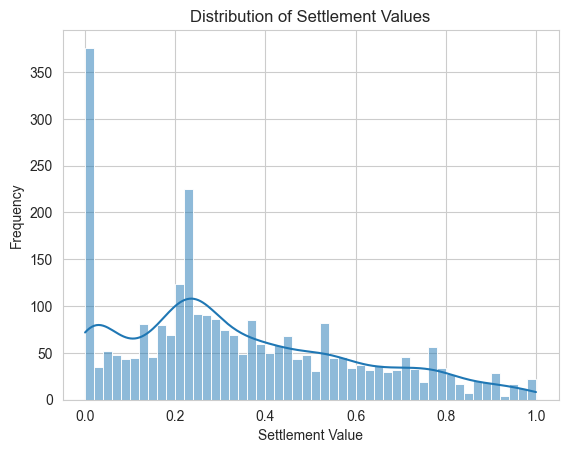

In [68]:
def settlement_value_histogram(data):
    sns.histplot(data['SettlementValue'], bins=50, kde=True)
    plt.title('Distribution of Settlement Values')
    plt.xlabel('Settlement Value')
    plt.ylabel('Frequency')
    plt.show()


settlement_value_histogram(dataset)

### Evaluating the Base Model:

In [69]:
X = dataset.drop('SettlementValue', axis=1)
y = dataset['SettlementValue']

X_np = X.values
y_np = y.values

print("Base model results: No hyperparameter tuning:")
base_mae, base_r2, base_actual, base_predicted = cross_validate_model(
    base_model, X_np, y_np, k_fold, scaler)

Base model results: No hyperparameter tuning:
Processing fold 1/5
Epoch 1/50


C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3801 - mae: 0.3801 - val_loss: 0.2004 - val_mae: 0.2004
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2631 - mae: 0.2631 - val_loss: 0.1940 - val_mae: 0.1940
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2330 - mae: 0.2330 - val_loss: 0.1925 - val_mae: 0.1925
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2186 - mae: 0.2186 - val_loss: 0.1965 - val_mae: 0.1965
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2054 - mae: 0.2054 - val_loss: 0.1894 - val_mae: 0.1894
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2040 - mae: 0.2040 - val_loss: 0.1907 - val_mae: 0.1907
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2028 - mae: 0.2028 - val_loss: 0.1873 - val_mae: 0.1873
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2099 - mae: 0.2099 - val_loss: 0.1859 - val_mae: 0.1859
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1984 - mae: 0.1984 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3770 - mae: 0.3770 - val_loss: 0.1944 - val_mae: 0.1944
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2385 - mae: 0.2385 - val_loss: 0.1922 - val_mae: 0.1922
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2271 - mae: 0.2271 - val_loss: 0.1956 - val_mae: 0.1956
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2111 - mae: 0.2111 - val_loss: 0.1878 - val_mae: 0.1878
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2058 - mae: 0.2058 - val_loss: 0.1875 - val_mae: 0.1875
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2042 - mae: 0.2042 - val_loss: 0.1997 - val_mae: 0.1997
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1983 - mae: 0.1983 - val_loss: 0.1883 - val_mae: 0.1883
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1891 - mae: 0.1891 - val_loss: 0.1935 - val_mae: 0.1935
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1915 - mae: 0.1915 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4757 - mae: 0.4757 - val_loss: 0.2024 - val_mae: 0.2024
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2362 - mae: 0.2362 - val_loss: 0.1949 - val_mae: 0.1949
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2238 - mae: 0.2238 - val_loss: 0.1898 - val_mae: 0.1898
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2078 - mae: 0.2078 - val_loss: 0.1922 - val_mae: 0.1922
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2074 - mae: 0.2074 - val_loss: 0.1885 - val_mae: 0.1885
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2039 - mae: 0.2039 - val_loss: 0.1876 - val_mae: 0.1876
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2065 - mae: 0.2065 - val_loss: 0.1882 - val_mae: 0.1882
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1898 - mae: 0.1898 - val_loss: 0.1851 - val_mae: 0.1851
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1958 - mae: 0.1958 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3303 - mae: 0.3303 - val_loss: 0.2165 - val_mae: 0.2165
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2347 - mae: 0.2347 - val_loss: 0.2032 - val_mae: 0.2032
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2193 - mae: 0.2193 - val_loss: 0.1949 - val_mae: 0.1949
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2097 - mae: 0.2097 - val_loss: 0.1933 - val_mae: 0.1933
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2078 - mae: 0.2078 - val_loss: 0.1948 - val_mae: 0.1948
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1999 - mae: 0.1999 - val_loss: 0.1916 - val_mae: 0.1916
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1957 - mae: 0.1957 - val_loss: 0.1906 - val_mae: 0.1906
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1962 - mae: 0.1962 - val_loss: 0.1904 - val_mae: 0.1904
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1916 - mae: 0.1916 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3265 - mae: 0.3265 - val_loss: 0.2175 - val_mae: 0.2175
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2495 - mae: 0.2495 - val_loss: 0.2238 - val_mae: 0.2238
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2245 - mae: 0.2245 - val_loss: 0.2082 - val_mae: 0.2082
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2091 - mae: 0.2091 - val_loss: 0.2125 - val_mae: 0.2125
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1981 - mae: 0.1981 - val_loss: 0.2097 - val_mae: 0.2097
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1920 - mae: 0.1920 - val_loss: 0.2047 - val_mae: 0.2047
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1906 - mae: 0.1906 - val_loss: 0.2060 - val_mae: 0.2060
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1870 - mae: 0.1870 - val_loss: 0.2036 - val_mae: 0.2036
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1913 - mae: 0.1913 - va

### Tuning the Hyper-Parameters:

In [70]:
tuner = kt.Hyperband(
    lambda hp: build_model(hp, X_np.shape[1]),
    objective='val_mae',
    max_epochs=75,
    factor=2,
    directory='tuner_results',
    project_name='neural_network_test',
    seed=42
)

# Use a single train-test split for hyperparameter tuning
X_train_tf = tf.convert_to_tensor(X_np, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_np, dtype=tf.float32)

early_stopping = EarlyStopping(
    monitor='val_mae', patience=10, restore_best_weights=True, verbose=1)

tuner.search(X_train_tf, y_train_tf, epochs=75, batch_size=32,
             validation_split=0.2, callbacks=[early_stopping])

best_hyper_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]


def tuned_model_builder(X_train_tf):
    return build_model(best_hyper_parameters, X_train_tf.shape[1])


tuned_mae, tuned_r2, tuned_actual, tuned_predicted = cross_validate_model(
    tuned_model_builder, X_np, y_np, k_fold, scaler)


Trial 359 Complete [00h 00m 12s]
val_mae: 0.1819349229335785

Best val_mae So Far: 0.17808134853839874
Total elapsed time: 00h 34m 12s
Processing fold 1/5
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0862 - mae: 0.2861 - val_loss: 0.0313 - val_mae: 0.2034
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340 - mae: 0.1989 - val_loss: 0.0298 - val_mae: 0.1933
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0323 - mae: 0.1945 - val_loss: 0.0296 - val_mae: 0.1934
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307 - mae: 0.1904 - val_loss: 0.0298 - val_mae: 0.1929
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304 - mae: 0.1882 - val_loss: 0.0295 - val_mae: 0.1837
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - mae: 0.1935 - val_loss: 0.0305 - val_mae: 0.1969
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - mae: 0.1957 - val_loss: 0.0309 - val_mae: 0.1971
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0868 - mae: 0.3011 - val_loss: 0.0358 - val_mae: 0.2211
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0347 - mae: 0.2015 - val_loss: 0.0315 - val_mae: 0.1981
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0335 - mae: 0.2001 - val_loss: 0.0317 - val_mae: 0.2015
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - mae: 0.1899 - val_loss: 0.0306 - val_mae: 0.1878
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0325 - mae: 0.1986 - val_loss: 0.0309 - val_mae: 0.1958
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - mae: 0.1942 - val_loss: 0.0311 - val_mae: 0.1867
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 - mae: 0.1913 - val_loss: 0.0313 - val_mae: 0.1879
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311 - mae: 0.1932 - val_loss: 0.0321 - val_mae: 0.1980
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - mae: 0.1867 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1092 - mae: 0.3186 - val_loss: 0.0387 - val_mae: 0.2304
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - mae: 0.1982 - val_loss: 0.0307 - val_mae: 0.1980
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - mae: 0.1964 - val_loss: 0.0297 - val_mae: 0.1900
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - mae: 0.1944 - val_loss: 0.0333 - val_mae: 0.2125
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - mae: 0.1977 - val_loss: 0.0287 - val_mae: 0.1841
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0308 - mae: 0.1903 - val_loss: 0.0277 - val_mae: 0.1825
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311 - mae: 0.1912 - val_loss: 0.0286 - val_mae: 0.1876
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313 - mae: 0.1944 - val_loss: 0.0312 - val_mae: 0.1859
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 - mae: 0.1913 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1082 - mae: 0.3161 - val_loss: 0.0346 - val_mae: 0.2162
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0342 - mae: 0.2000 - val_loss: 0.0311 - val_mae: 0.1975
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329 - mae: 0.1957 - val_loss: 0.0311 - val_mae: 0.1916
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - mae: 0.1952 - val_loss: 0.0316 - val_mae: 0.2030
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - mae: 0.1941 - val_loss: 0.0309 - val_mae: 0.1878
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 - mae: 0.1895 - val_loss: 0.0302 - val_mae: 0.1880
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - mae: 0.1885 - val_loss: 0.0317 - val_mae: 0.2044
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293 - mae: 0.1858 - val_loss: 0.0320 - val_mae: 0.2023
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286 - mae: 0.1869 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1162 - mae: 0.3167 - val_loss: 0.0362 - val_mae: 0.2186
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - mae: 0.1918 - val_loss: 0.0365 - val_mae: 0.2207
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0308 - mae: 0.1912 - val_loss: 0.0368 - val_mae: 0.2204
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 - mae: 0.1877 - val_loss: 0.0344 - val_mae: 0.2071
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 - mae: 0.1872 - val_loss: 0.0345 - val_mae: 0.2069
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - mae: 0.1796 - val_loss: 0.0336 - val_mae: 0.2057
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - mae: 0.1849 - val_loss: 0.0342 - val_mae: 0.2044
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - mae: 0.1833 - val_loss: 0.0338 - val_mae: 0.2023
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - mae: 0.1833 - va

### Printing the Errors for the Tuned and Un-tuned models:

In [71]:
print("Average Mean Absolute Error for un-tuned model:", base_mae)
print("Average R² Score for un-tuned model:", base_r2)

print("Average Mean Absolute Error for tuned model:", tuned_mae)
print("Average R² Score for tuned model:", tuned_r2)

Average Mean Absolute Error for un-tuned model: 314.42437143648675
Average R² Score for un-tuned model: 0.11554166129910196
Average Mean Absolute Error for tuned model: 310.1801579376433
Average R² Score for tuned model: 0.16012568689061837


### Plotting the Predicted vs Actual Settlement Values for the Tuned and Un-tuned models:

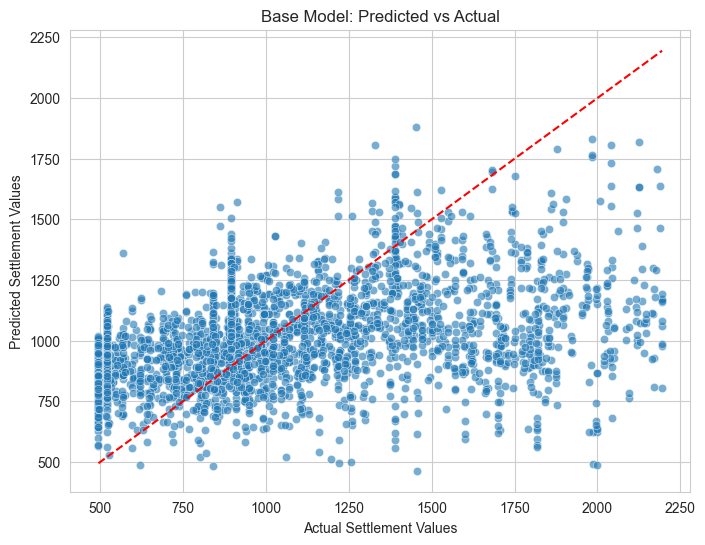

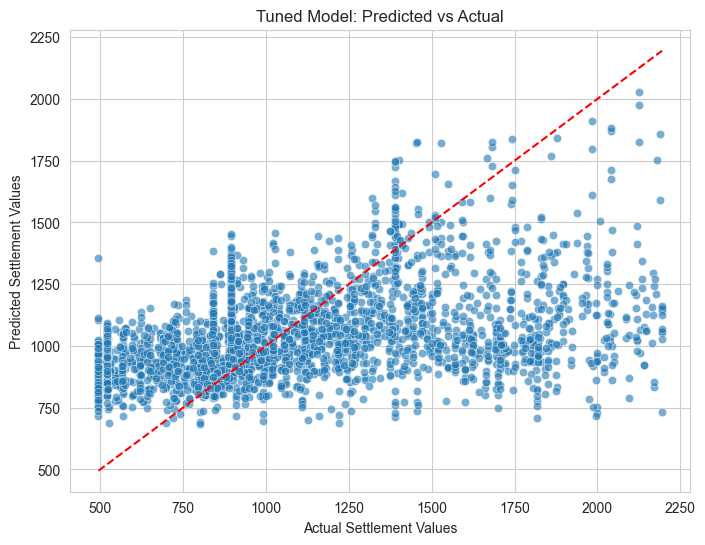

In [72]:
plot_predicted_vs_actual(base_actual, base_predicted,
                         "Base Model: Predicted vs Actual")
plot_predicted_vs_actual(tuned_actual, tuned_predicted,
                         "Tuned Model: Predicted vs Actual")